<div style="font-variant: small-caps; 
      font-weight: normal; 
      font-size: 35px; 
      text-align: center; 
      padding: 15px; 
      margin: 10px;">
      Dataset processing
  </div> 
  
<div style="
      font-weight: normal; 
      font-size: 25px; 
      text-align: center; 
      padding: 15px; 
      margin: 10px;">
      Leaf Clinical Trials
  </div>


  <div style=" float:left; 
      font-size: 12px; 
      line-height: 12px; 
  padding: 10px 15px 8px;">
  Jean-baptiste AUJOGUE -  Hybrid Intelligence
  </div> 


<a id="TOC"></a>

##### Table Of Content

1. [LCT Texts](#texts) <br>
2. [LCT base Entities](#ents) <br>
3. [LCT Graph](#graph) <br>
4. [LCT Entities mapped to CHIA format](#ents_chia) <br>


#### Useful links

- The Leaf Clinical Trials Corpus: a new resource for query generation from clinical trial eligibility criteria, [paper](https://www.nature.com/articles/s41597-022-01521-0), [dataset](https://figshare.com/articles/dataset/lct_corpus_tar_gz/17209610), [github](https://github.com/uw-bionlp/clinical-trials-gov-data)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import re
import copy
import json
import tarfile

# data
import numpy as np
import pandas as pd
import networkx as nx

# text
from spacy.lang.en import English

# viz
import pyvis.network as nt

C:\Users\jb\miniconda3\envs\transformers_nlp\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Custom variables

In [3]:
path_to_repo = os.path.dirname(os.getcwd())
path_to_data = os.path.join(path_to_repo, 'datasets', 'lct')
path_to_src  = os.path.join(path_to_repo, 'src')
path_to_src

'C:\\Users\\jb\\Desktop\\NLP\\perso - Transformers for NLP\\src'

In [4]:
base_dataset_name  = 'lct_corpus.tar.gz'
final_dataset_name = 'lct-ner'

#### Custom imports

In [5]:
sys.path.insert(0, path_to_src)

In [6]:
from nlptools.dataset.chia.preprocessing import get_ner_entities, convert_to_bio

<a id="texts"></a>

# 1. LCT Texts

[Table of content](#TOC)

In [7]:
def load_texts_from_targzfile(targz_file):
    with tarfile.open(targz_file, "r:gz") as archive:
        text_files = [(f.name, f) for f in archive.getmembers() if f.name.endswith('.txt')]
        texts = []
        for name, member in text_files:
            f = archive.extractfile(member)
            if f is not None:
                _id = name.split('/')[-1][:-4]
                text = f.read().decode('utf-8').replace('⁄', '/')
                texts.append([_id, text])
            
    df_texts = pd.DataFrame(texts, columns = ['Id', 'Text'])
    return df_texts

In [8]:
folder = os.path.join(path_to_data, final_dataset_name)
if not os.path.isdir(folder):
    os.makedirs(folder)

In [9]:
df_texts = load_texts_from_targzfile(os.path.join(path_to_data, base_dataset_name))

In [10]:
df_texts.head()

,Id,Text
0,NCT03862404,"Inclusion Criteria:\n - Male and Female, bet..."
1,NCT03861858,Inclusion Criteria:\n - Age 13-17 years or 1...
2,NCT03869021,Inclusion Criteria:\n 1. Patients free from a...
3,NCT03864263,Inclusion Criteria:\n - The father or (and) ...
4,NCT03862612,Inclusion Criteria:\n - Male and Female part...


In [11]:
df_texts.shape

(1006, 2)

In [12]:
df_texts.to_csv(os.path.join(path_to_data, final_dataset_name, 'lct_texts.tsv'), sep = "\t", index = False)

In [13]:
# sanity check : no overlap with chia
df_chia = pd.read_csv(os.path.join(path_to_repo, 'datasets', 'chia', 'chia-ner', 'chia_texts.tsv'), sep = "\t")

chia_ids = set([t.split('_')[0] for t in df_chia.Id.tolist()])
lct_ids  = set(df_texts.Id.tolist())
print(
    len(chia_ids & lct_ids),
    len(lct_ids - chia_ids),
    len(chia_ids - lct_ids),
)

0 1006 1000


<a id="ents"></a>

# 2. LCT base Entities

[Table of content](#TOC)

## 2.1 Load entities as single spans

[Table of content](#TOC)


#### Remark

Entities are multi-spanned, and are here replaced by their full spans

In [14]:
def load_entity_line(l):
    ent = l.split('\t')
    ent_id = ent[0]
    ent_txt = ent[2]
    ent_cat = ent[1].replace(';', ' ').split(' ')[0]
    spans = tuple([int(v) for v in ent[1].replace(';', ' ').split(' ')[1:]])
    return [ent_id, ent_txt, ent_cat, min(spans), max(spans), spans]



def load_entities_from_targzfile(targz_file):
    with tarfile.open(targz_file, "r:gz") as archive:
        ann_files = [(f.name, f) for f in archive.getmembers() if f.name.endswith('.ann')]
        ent_list = []
        for name, member in ann_files:
            f = archive.extractfile(member)
            if f is not None:
                _id = name.split('/')[-1][:-4]
                lines = [l.decode('utf-8').replace('⁄', '/').strip() for l in f.readlines()]
                ents = [[_id] + load_entity_line(l) for l in lines if l.startswith('T')]
                ent_list += ents
            
    df_ents = pd.DataFrame(ent_list, columns = [
        'Id', 'Entity_id', 'Mention', 'Category', 'Start_char', 'End_char', 'Char_spans',
    ])
    return df_ents

In [15]:
df_ents = load_entities_from_targzfile(os.path.join(path_to_data, base_dataset_name))
df_ents.shape

(56093, 7)

In [16]:
# A sanity check:
check = []
for _id, text in df_texts.values.tolist():
    df_tmp = df_ents[df_ents.Id == _id]
    check_tmp = df_tmp.apply(
        func = lambda r: [_id, r.Mention, text[r.Start_char: r.End_char]],
        axis = 1,
    ).tolist()
    check += check_tmp
    
df_check = pd.DataFrame(check, columns = ['Id', 'Mention', 'Span'])

# Mention and Span are indeed the same for all entities:
df_check[df_check.Mention != df_check.Span]

,Id,Mention,Span


In [17]:
df_ents.head()

,Id,Entity_id,Mention,Category,Start_char,End_char,Char_spans
0,NCT03865342,T1,diabetes,Condition,387,395,"(387, 395)"
1,NCT03865342,T2,diabetes,Condition-Name,387,395,"(387, 395)"
2,NCT03865342,T3,English,Language,25,32,"(25, 32)"
3,NCT03865342,T4,given birth,Condition,661,672,"(661, 672)"
4,NCT03865342,T5,given birth,Condition-Name,661,672,"(661, 672)"


## 2.2 Get flattened non-overlapping entities

[Table of content](#TOC)

See the list of categories at [Leaf CT Wiki](https://github.com/uw-bionlp/clinical-trials-gov-annotation/wiki)

In [18]:
categories = [
    # Demographics & Family
    # ---------------------
    'Age',
    # 'Ethnicity',
    # 'Family-Member',
    # 'Language',
    'Life-Stage-And-Gender',
    
    
    # Biomedical
    # ----------
    'Allergy',
    # 'Birth',
    'Condition',
    # 'Death',
    'Drug',
     # 'Encounter',
    'Immunization',
    'Observation',
    'Organism',
    'Procedure',
    # 'Provider',
    
    
    # Boolean, Negations, & Conjunctives
    # ----------------------------------
    'And',
    'Assertion',
    'Exception',
    'Negation',
    'Or',
    
    
    # Temporal & Numerical
    # --------------------
    'Equality-Comparison',
    'Temporal-Connection',
    # 'Other',
    'Acuteness',
    'Contraindication',
    # 'Coreference',
    'Criteria-Count',
    'Indication',
    # 'Location',
    'Modifier',
    # 'Other',
    'Polarity',
    # 'Risk',
    'Severity',
    'Stability',
    # 'Study',
]

In [19]:
df_flat = get_ner_entities(df_texts, df_ents, categories)
df_flat.shape

(23017, 6)

In [20]:
df_flat.head()

,Id,Mention,Start_char,End_char,Entity_id,Category
0,NCT03860012,inflammatory bowel disease,25,51,"(T13,)",Condition
1,NCT03860012,methotrexate,60,72,"(T15,)",Drug
2,NCT03860012,normal,100,106,"(T19,)",Polarity
3,NCT03860012,folate levels,107,120,"(T17,)",Observation
4,NCT03860012,treatment,144,153,"(T26,)",Procedure


In [21]:
df_flat.to_csv(os.path.join(path_to_data, final_dataset_name, 'lct_ents_base.tsv'), sep = "\t", index = False)

## 2.3 Convert entities to BIO format

[Table of content](#TOC)


In [22]:
df_spans = convert_to_bio(df_texts, df_flat)
df_spans.shape

(53897, 4)

In [23]:
df_spans.head()

,Id,Sequence_id,Mention,Category
0,NCT03862404,NCT03862404_0,Inclusion Criteria:,O
1,NCT03862404,NCT03862404_1,-,O
2,NCT03862404,NCT03862404_1,Male,Life-Stage-And-Gender
3,NCT03862404,NCT03862404_1,and,O
4,NCT03862404,NCT03862404_1,Female,Life-Stage-And-Gender


In [24]:
df_spans.to_csv(os.path.join(path_to_data, final_dataset_name, 'lct_spans_base.tsv'), sep = "\t", index = False)

In [25]:
tokenizer = English()

df_bio = convert_to_bio(df_texts, df_flat, tokenizer = lambda s: [t.text for t in tokenizer(s)])
df_bio.shape

(147901, 4)

In [26]:
df_bio.head(10)

,Id,Sequence_id,Mention,Category
0,NCT03862404,NCT03862404_0,Inclusion,O
1,NCT03862404,NCT03862404_0,Criteria,O
2,NCT03862404,NCT03862404_0,:,O
3,NCT03862404,NCT03862404_1,,O
4,NCT03862404,NCT03862404_1,-,O
5,NCT03862404,NCT03862404_1,,O
6,NCT03862404,NCT03862404_1,Male,B-Life-Stage-And-Gender
7,NCT03862404,NCT03862404_1,,O
8,NCT03862404,NCT03862404_1,and,O
9,NCT03862404,NCT03862404_1,Female,B-Life-Stage-And-Gender


In [27]:
df_bio.to_csv(os.path.join(path_to_data, final_dataset_name, 'lct_bio_base.tsv'), sep = "\t", index = False)

<a id="graph"></a>

# 3. LCT Graph

[Table of content](#TOC)

## 3.1 Load LCT dataset into graph

[Table of content](#TOC)

#### Remark

Entities are multi-spanned, and are here replaced by their full spans

In [28]:
def load_graph_from_targzfile(targz_file):
    with tarfile.open(targz_file, "r:gz") as archive:
        ann_files = [(f.name, f) for f in archive.getmembers() if f.name.endswith('.ann')]
        all_nodes = []
        all_edges = []
        for name, member in ann_files:
            f = archive.extractfile(member)
            if f is not None:
                _id = name.split('/')[-1][:-4]
                lines = [l.decode('utf-8').replace('⁄', '/').strip() for l in f.readlines()]

                # load node attributes as attr-name / target-id / attr-value
                a_attrs = [l.replace('\t', ' ').split(' ')[-3:] for l in lines if l.startswith('A')]

                # load nodes corresponding to textual entities
                t_nodes = [load_entity_line(l) for l in lines if l.startswith('T')]
                t_nodes = [{
                    'Node_id': '-'.join((_id, n[0])),
                    'Study_id': _id,
                    'Entity_id': n[0],
                    'Mention': n[1],
                    'Category': n[2],
                    'Start_char': n[3],
                    'End_char': n[4],
                    'Char_spans': n[5],
                    'Normalization': [(a[0], a[-1]) for a in a_attrs if a[-2] == n[0]], # (a_attrs['-'.join((_id, n[0]))] if '-'.join((_id, n[0])) in a_attrs else ''),
                    'Letter': 'T',
                    } 
                    for n in t_nodes
                ]

                # load nodes corresponding to metadata 
                e_nodes = [l.replace('\t', ' ').split(' ') for l in lines if l.startswith('E')]
                e_nodes = [{
                    'Node_id': '-'.join((_id, n[0])),
                    'Study_id': _id,
                    'Entity_id': n[0],
                    'Mention': '',
                    'Category': '',
                    'Start_char': '',
                    'End_char': '',
                    'Char_spans': tuple(),
                    'Normalization': [(a[0], a[-1]) for a in a_attrs if a[-2] == n[0]], # (a_attrs['-'.join((_id, n[0]))] if '-'.join((_id, n[0])) in a_attrs else ''),
                    'Letter': 'E',
                    } 
                    for n in e_nodes
                ]
                nodes = t_nodes + e_nodes
                nodes = [(n['Node_id'], n) for n in nodes]
                
                # load edges carrying relationships
                e_edges = [l.replace('\t', ' ').split(' ') for l in lines if l.startswith('E')]
                e_edges = [{
                    's': '-'.join((_id, es[0])),
                    't': '-'.join((_id, e.split(':')[1])),
                    'Edge_id': es[0],
                    'label': e.split(':')[0],
                    } 
                    for es in e_edges for e in es[1:] if (':' in e)
                ]
                
                # load edges carrying meta-relations
                r_edges = [l.replace('\t', ' ').split(' ')[:4] for l in lines if l.startswith('R')]
                r_edges = [{
                    's': '-'.join((_id, s.split(':')[1])),
                    't': '-'.join((_id, t.split(':')[1])),
                    'Edge_id': e_id,
                    'label': label,
                    } 
                    for e_id, label, s, t in r_edges
                ]
                edges = e_edges + r_edges
                edges = [(e['s'], e['t'], e) for e in edges]
                
                all_nodes += nodes
                all_edges += edges
            
    nx_graph = nx.MultiDiGraph()
    nx_graph.add_nodes_from(all_nodes)
    nx_graph.add_edges_from(all_edges)
    return nx_graph

In [29]:
nx_graph = load_graph_from_targzfile(os.path.join(path_to_data, base_dataset_name))

## 3.2 Visualize graph

[Table of content](#TOC)


In [30]:
def filter_by_study(nx_graph, study):
    nodes = [n for n in nx_graph.nodes() if nx_graph.nodes[n]['Study_id'] == study]
    return nx_graph.subgraph(nodes)


def convert_nx_to_nt_graph(nx_graph, node_colors = {}, edge_weights = {}, height = 1200, width = 1980, notebook = False):
    nodes = list(nx_graph.nodes(data = True))
    edges = [(s, t, 1 + (edge_weights[e['label']] if e['label'] in edge_weights else 0)) for s, t, e in nx_graph.edges(data = True)]
    color = [(node_colors[k] if k in node_colors else '#edc939') for k, n in nodes]
    
    nt_graph = nt.Network(directed = True, height = height, width = width, notebook = notebook)
    nt_graph.add_nodes(
        nodes = [k for k, n in nodes],
        size  = [10]*len(nodes),
        label = [n['Mention'] for k, n in nodes],
        title = [n['Category'] for k, n in nodes],
        color = color,
    )
    nt_graph.add_edges(edges)
    return nt_graph

In [31]:
study = 'NCT03931941'
study = 'NCT03860038'

In [32]:
print(df_texts[df_texts.Id == study].Text.tolist()[0])

Inclusion criteria:
  1. Age ≥ 18, male or female;
  2. Subject must have had documented MM;
  3. At screening phase, subject must have measurable disease;
  4. Subject is in a state of progressive disease (PD);
  5. Subject must have life expectancy of no less than 6 months;
  6. Subject must have an ECOG (Eastern Cooperative Oncology Group) performance status score of 0~2;
Exclusion criteria:
  1. Subject has received anti-CD38 monoclonal antibody treatment previously;
  2. Subject has received CAR-T cell therapy previously;
  3. Subject has previously received allogenic stem cell transplant, or subject has received autologous stem cell transplant within 3 months before administration of the study agent;
  4. Primary refractory multiple myeloma (subject failed to generate any minimal response or any degree of response to any therapy);
  5. Subject has received anti-myeloma treatment (radiotherapy is excluded) within 4 weeks or 5 PK half-lives of the treatment, whichever longer, befor

In [33]:
nx_subgraph = filter_by_study(nx_graph, study = study)
nt_subgraph = convert_nx_to_nt_graph(
    nx_subgraph, 
    node_colors = {}, 
    edge_weights = {'Temporality': 5, 'Modifies': 15},
    height = 600, 
    width = 900, 
    notebook = True,
)
nt_subgraph.save_graph(os.path.join('lct', 'misc', 'lct.html'))

nt_subgraph.show(os.path.join('lct', 'misc', 'lct.html'))

In [34]:
[e for s, t, e in nx_subgraph.edges(data = True) if e['s'] == 'NCT03860038-E21']

[{'s': 'NCT03860038-E21',
  't': 'NCT03860038-T36',
  'Edge_id': 'E21',
  'label': 'Eq-Comparison'},
 {'s': 'NCT03860038-E21',
  't': 'NCT03860038-T21',
  'Edge_id': 'E21',
  'label': 'Operator'},
 {'s': 'NCT03860038-E21',
  't': 'NCT03860038-T24',
  'Edge_id': 'E21',
  'label': 'Temporal-Unit'},
 {'s': 'NCT03860038-E21',
  't': 'NCT03860038-T31',
  'Edge_id': 'E21',
  'label': 'Value'},
 {'s': 'NCT03860038-E21',
  't': 'NCT03860038-E27',
  'Edge_id': 'R6',
  'label': 'Before'}]

<a id="ents_chia"></a>

# 4. LCT Entities mapped to CHIA format

[Table of content](#TOC)

## 4.1 Add Entity Type

[Table of content](#TOC)


In [35]:
def get_parent_type(nx_graph, node_id):
    '''
    This function rely on the fact that each node has a single parent,
    and its normalization is unique, if it exists.
    '''
    p_type = ''
    parent = list(nx_graph.predecessors(node_id))
    if parent:
        p_type = nx_graph.nodes[parent[0]]['Normalization']
        p_type = (p_type[0][-1] if p_type else '')
    return p_type

In [36]:
df_ents.loc[:, 'Category_chia'] = df_ents.Category

In [37]:
df_ents.loc[:, 'Type'] = df_ents.apply(
    func = lambda r: get_parent_type(nx_graph, '-'.join([r.Id, r.Entity_id])),
    axis = 1,
).tolist()

In [59]:
df_ents.shape

(56093, 9)

In [39]:
df_ents

,Id,Entity_id,Mention,Category,Start_char,End_char,Char_spans,Category_chia,Type
0,NCT03865342,T1,diabetes,Condition,387,395,"(387, 395)",Condition,
1,NCT03865342,T2,diabetes,Condition-Name,387,395,"(387, 395)",Condition-Name,
2,NCT03865342,T3,English,Language,25,32,"(25, 32)",Language,
3,NCT03865342,T4,given birth,Condition,661,672,"(661, 672)",Condition,
4,NCT03865342,T5,given birth,Condition-Name,661,672,"(661, 672)",Condition-Name,
...,...,...,...,...,...,...,...,...,...
56088,NCT03931772,T98,motivation,Assertion,136,146,"(136, 146)",Assertion,intention
56089,NCT03931772,T100,or older,Eq-Operator,34,42,"(34, 42)",Eq-Operator,
56090,NCT03931772,T65,quit smoking,Observation,167,179,"(167, 179)",Observation,
56091,NCT03931772,T97,10-point Likert-type scale,Modifier,185,211,"(185, 211)",Modifier,


<AxesSubplot: >

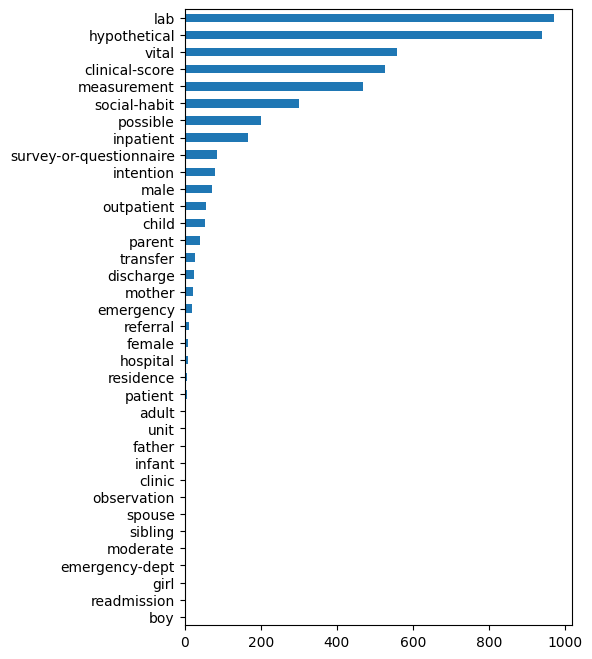

In [66]:
df_ents[(df_ents.Type != '')].Type.value_counts().sort_values().plot(kind = 'barh', figsize = (5, 8))

<AxesSubplot: >

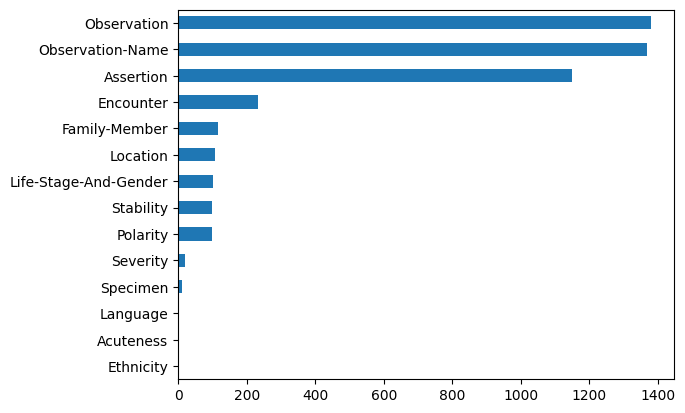

In [41]:
df_ents[(df_ents.Type != '')].Category.value_counts().sort_values().plot(kind = 'barh')

In [68]:
df_ents[(df_ents.Category == 'Polarity') & (df_ents.Type.isin([
    'measurement',
    'lab',
    'vital',
    'clinical-score',
]))]

,Id,Entity_id,Mention,Category,Start_char,End_char,Char_spans,Category_chia,Type
251,NCT03869593,T68,positive,Polarity,109,117,"(109, 117)",Polarity,lab
506,NCT03867019,T90,Positive,Polarity,304,312,"(304, 312)",Polarity,clinical-score
2912,NCT03867214,T51,normal,Polarity,250,256,"(250, 256)",Polarity,lab
2915,NCT03867214,T54,normal,Polarity,286,292,"(286, 292)",Polarity,lab
2918,NCT03867214,T57,normal,Polarity,311,317,"(311, 317)",Polarity,lab
...,...,...,...,...,...,...,...,...,...
53182,NCT03867617,T103,Positive,Polarity,997,1005,"(997, 1005)",Polarity,lab
53195,NCT03867617,T116,positive,Polarity,1439,1447,"(1439, 1447)",Polarity,lab
54012,NCT03860350,T189,outside the reference ranges,Polarity,1456,1484,"(1456, 1484)",Polarity,lab
54979,NCT03865407,T38,Elevated,Polarity,157,165,"(157, 165)",Polarity,lab


## 4.2 Build _Person_ category

[Table of content](#TOC)


In [42]:
# Person : we ignored Ethnicity, Family-member, Language
person_idx = df_ents.Category.isin(['Life-Stage-And-Gender', 'Age']) 

In [58]:
sum(person_idx)

1436

In [44]:
df_ents.loc[person_idx, 'Category_chia'] = 'Person'

## 4.3 Merge _Modifier_ with Domain entities

[Table of content](#TOC)

Modifiers are a special kind of entities in the Leaf CT corpus scheme, and are always linked to one or more _Domain_ entities to which the modification applies.


#### Necessity to merge Modifiers

There are two problems regarding these entities:

1. Oftentimes, multi-word entities are broken down into a core _Domain_ entity (e.g. _Condition_, etc) and a bunch of _Modifiers_. This makes the reconsitution of the full entity complex and error-prone, since it involves a subsequent Relation Extraction processing, yet it is necessary to correctly code such term in the OMOP coding scheme.

2. It is expected that this labelling of entities will be reviewed and complemented by human annotation. However cautiously dissociating core _Domain_ entities and related _Modifiers_ is a painful task for the human, which goes in favor of an simplier annotation scheme carrying longer, _Domain_-only entities with associated qualifiers directly integrated into these entities.

For these two reasons, we attempt to **merge Modifier entities with their target Domain entities**.


#### Strategy for merging Modifiers


_Modifiers_ are linked with their domain entity through the following patterns:

- `T_modifier <--Modifier-- E --Modifies--> T_domain`

- `T_modifier <--Modifier-- E --Modifies--> E --Domain--> T_domain`

Some longer patterns are necessary when a coordinating conjunction lies along the path, and for simplicity we chose to merge Modifiers matching the above pattern, **and disregard the others**.
  
  
For other Qualifiers, the relationship follows an _attributive_ scheme with pattern:

`T_domain <--Domain-- E --Qualifier--> T_qualifier`

All attributes are linked to their domain entity through this pattern ? We chose to merge Attributes matching the above pattern.

In [60]:
df_ents[df_ents.Category == 'Modifier']

,Id,Entity_id,Mention,Category,Start_char,End_char,Char_spans,Category_chia,Type
42,NCT03865342,T23,type 1,Modifier,370,376,"(370, 376)",Modifier,
44,NCT03865342,T56,persistent,Modifier,412,422,"(412, 422)",Modifier,
71,NCT03865342,T24,type 2,Modifier,380,386,"(380, 386)",Modifier,
120,NCT03861130,T53,Convalescent,Modifier,491,503,"(491, 503)",Modifier,
144,NCT03861130,T35,hands,Modifier,476,481,"(476, 481)",Modifier,
...,...,...,...,...,...,...,...,...,...
56001,NCT03931941,T135,systemic,Modifier,879,887,"(879, 887)",Modifier,
56060,NCT03931772,T69,psychiatric,Modifier,565,576,"(565, 576)",Modifier,
56061,NCT03931772,T70,structural,Modifier,580,590,"(580, 590)",Modifier,
56082,NCT03931772,T90,auditory,Modifier,836,844,"(836, 844)",Modifier,


In [ ]:
measurement_idx = (
    (df_ents.Category == 'Observation')
) & df_ents.Type.isin([
    'measurement',
    'lab',
    'vital',
    'clinical-score',
])

In [74]:
df_ents[df_ents.Category.isin([
    # 'Modifier', 
    'Severity', 
    'Stability', 
    'Acuteness', 
]) & df_ents.Type.isin([
    'measurement',
    'lab',
    'vital',
    'clinical-score',
])]

,Id,Entity_id,Mention,Category,Start_char,End_char,Char_spans,Category_chia,Type
2613,NCT03867422,T29,impact,Stability,249,255,"(249, 255)",Stability,measurement
3340,NCT03867994,T122,unstable,Stability,870,878,"(870, 878)",Stability,vital
3457,NCT03862807,T93,significant,Severity,536,547,"(536, 547)",Severity,lab
4547,NCT03862027,T127,Variation,Stability,945,954,"(945, 954)",Stability,lab
7246,NCT03867773,T55,stable,Stability,253,259,"(253, 259)",Stability,vital
12286,NCT03929549,T65,significant,Severity,170,181,"(170, 181)",Severity,vital
12287,NCT03929549,T66,changes,Stability,189,196,"(189, 196)",Stability,vital
13961,NCT03929328,T82,stable,Stability,679,685,"(679, 685)",Stability,vital
15381,NCT03924440,T43,inconsistent,Stability,226,238,"(226, 238)",Stability,lab
15919,NCT03926806,T27,Constant,Stability,58,66,"(58, 66)",Stability,vital


<AxesSubplot: >

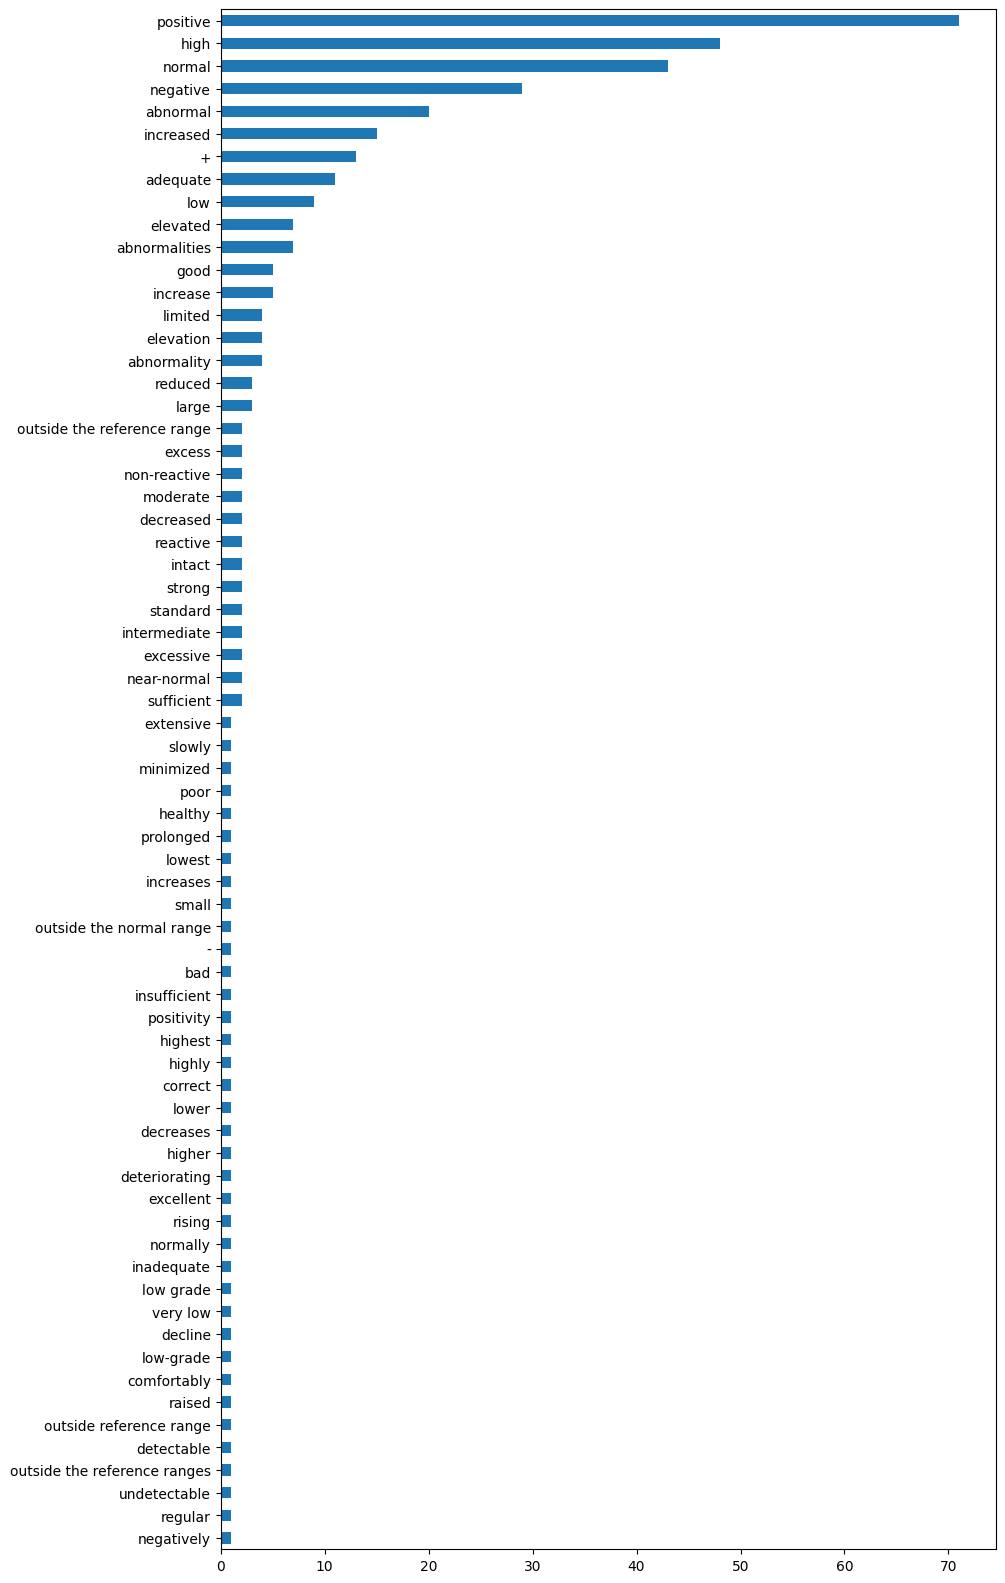

In [57]:
df_ents[df_ents.Category == 'Polarity'].Mention.apply(lambda s: s.lower()).value_counts().sort_values().plot(kind = 'barh', figsize = (10, 20))

In [47]:
df_ents[df_ents.Mention.apply(lambda s: s.lower()) == 'positive']

,Id,Entity_id,Mention,Category,Start_char,End_char,Char_spans,Category_chia,Type
251,NCT03869593,T68,positive,Polarity,109,117,"(109, 117)",Polarity,lab
506,NCT03867019,T90,Positive,Polarity,304,312,"(304, 312)",Polarity,clinical-score
1055,NCT03861078,T18,positive,Polarity,423,431,"(423, 431)",Polarity,
4136,NCT03865953,T88,Positive,Polarity,689,697,"(689, 697)",Polarity,
4344,NCT03860181,T56,positive,Polarity,871,879,"(871, 879)",Polarity,
...,...,...,...,...,...,...,...,...,...
53175,NCT03867617,T96,positive,Polarity,842,850,"(842, 850)",Polarity,
53181,NCT03867617,T102,positive,Polarity,976,984,"(976, 984)",Polarity,
53182,NCT03867617,T103,Positive,Polarity,997,1005,"(997, 1005)",Polarity,lab
53195,NCT03867617,T116,positive,Polarity,1439,1447,"(1439, 1447)",Polarity,lab


In [53]:
print(df_texts[df_texts.Id == 'NCT03865953'].Text.to_list()[0])

Inclusion Criteria:
  1. Clinical diagnosis of post herpetic neuralgia, with pain persisting for at least 3 months after the onset of herpes zoster rash OR
  2. Clinical diagnosis of distal painful polyneuropathy due to Type I or Type II diabetes mellitus with:
       1. symmetrical, bilateral pain in the lower extremities for at least 3 months and
       2. diabetes under control for at least 3 months prior to randomisation, as indicated by a glycated haemoglobin level (HbA1c) of ≤ 11% (97 mmol/mol) and on a stable dose of insulin or oral diabetic medication for 3 months prior to screening, and
       3. no change in diabetic medication planned for the duration of the study
  3. Positive sensory symptoms (mechanical or thermal) associated with neuropathic pain, confirmed by:
       1. painDETECT questionnaire (PD-Q) and
       2. Clinical assessment, showing signs of neuropathic pain in either a dermatomal (PHN) or distal symmetrical distribution (DPN)
8. An average daily pain score o

In [242]:
def get_modifier_mapping(nx_graph):
    '''
    This function rely on the fact that each node has a single parent,
    and its normalization is unique, if it exists.
    '''
    modifier_mapping = {}
    
    n_modifiers = [n for n in nx_graph.nodes() if nx_graph.nodes[n]['Category'] == 'Modifier']
    for src in n_modifiers:
        t_tar = []
        parents = list(nx_graph.predecessors(src))
        if parents:
            parent = parents[0]
            edges = [t for (s, t, e) in nx_graph.out_edges(parent, data = True) if e['label'] == 'Modifies']
            t_tar = [t for t in edges if nx_graph.nodes[t]['Letter'] == 'T']
            e_tar = [t for t in edges if nx_graph.nodes[t]['Letter'] == 'E']
            t_tar += [
                t 
                for e_node in e_tar
                for (s, t) in nx_graph.out_edges(e_node) 
                if nx_graph.nodes[t]['Letter'] == 'T'
            ]
        modifier_mapping[src] = t_tar
    return modifier_mapping



def compute_domain_to_modifier_spans(df_ents, nx_graph):
    ent_ids = df_ents.apply(func = lambda r: '-'.join([r.Id, r.Entity_id]), axis = 1).to_list()
    
    # compute span of each modifier
    modifier_2_span = df_ents[df_ents.Category == 'Modifier'].apply(
        func = lambda r: ('-'.join([r.Id, r.Entity_id]), r.Char_spans), 
        axis = 1,
    ).to_list()
    modifier_2_span = {k: v for k, v in modifier_2_span}

    # compute target domain entities of each modifier
    modifier_2_domain = get_modifier_mapping(nx_graph)

    # compute modifiers of each domain entity
    domain_2_modifier = list(np.unique([d for ds in modifier_2_domain.values() for d in ds if d in ent_ids]))
    domain_2_modifier = {d: [m for m in modifier_2_domain if d in modifier_2_domain[m]] for d in domain_2_modifier}

    # compute modifier spans of each domain entity
    domain_2_span = {d: [s for m in ms for s in modifier_2_span[m]] for d, ms in domain_2_modifier.items()}
    domain_2_span = {d: (min(s), max(s)) for d, s in domain_2_span.items()}
    return domain_2_span

In [243]:
domain_2_span = compute_domain_to_modifier_spans(df_ents, nx_graph)

In [244]:
df_ents[(df_ents.Id == 'NCT03860038')]

,Id,Entity_id,Mention,Category,Start_char,End_char,Char_spans,Category_chia,Type
591,NCT03860038,T1,stem cell transplant,Procedure,580,600,"(580, 600)",Procedure,
592,NCT03860038,T2,stem cell transplant,Procedure-Name,580,600,"(580, 600)",Procedure-Name,
593,NCT03860038,T3,stem cell transplant,Procedure,637,657,"(637, 657)",Procedure,
594,NCT03860038,T4,stem cell transplant,Procedure-Name,637,657,"(637, 657)",Procedure-Name,
595,NCT03860038,T5,progressive disease,Condition,186,205,"(186, 205)",Condition,
...,...,...,...,...,...,...,...,...,...
659,NCT03860038,T66,agent,Drug,1018,1023,"(1018, 1023)",Drug,
660,NCT03860038,T80,first,Eq-Comparison,1006,1011,"(1006, 1011)",Eq-Comparison,
661,NCT03860038,T81,first,Eq-Temporal-Recency,1006,1011,"(1006, 1011)",Eq-Temporal-Recency,
662,NCT03860038,T82,treatment,Procedure,454,463,"(454, 463)",Procedure,


In [245]:
domain_2_span

{'NCT03860025-T15': (118, 125),
 'NCT03860025-T5': (85, 92),
 'NCT03860038-T1': (570, 579),
 'NCT03860038-T2': (570, 579),
 'NCT03860038-T3': (626, 636),
 'NCT03860038-T4': (626, 636),
 'NCT03860038-T59': (721, 739),
 'NCT03860038-T71': (345, 369),
 'NCT03860038-T72': (345, 369),
 'NCT03860064-T41': (230, 234),
 'NCT03860064-T47': (87, 93),
 'NCT03860103-T24': (152, 162),
 'NCT03860116-T23': (375, 393),
 'NCT03860142-T2': (271, 301),
 'NCT03860142-T27': (77, 101),
 'NCT03860142-T31': (233, 250),
 'NCT03860142-T7': (77, 101),
 'NCT03860181-T2': (88, 95),
 'NCT03860181-T33': (468, 483),
 'NCT03860181-T34': (468, 483),
 'NCT03860181-T4': (705, 716),
 'NCT03860181-T5': (496, 500),
 'NCT03860181-T6': (496, 500),
 'NCT03860181-T61': (946, 950),
 'NCT03860181-T74': (1080, 1086),
 'NCT03860181-T8': (748, 819),
 'NCT03860220-T41': (181, 192),
 'NCT03860220-T43': (209, 229),
 'NCT03860233-T62': (516, 539),
 'NCT03860246-T45': (373, 383),
 'NCT03860246-T49': (478, 485),
 'NCT03860259-T22': (163, 

In [246]:
len(domain_2_span)

2649

In [247]:
def merge_spans(r, domain_2_span):
    _id = '-'.join([r.Id, r.Entity_id])
    if _id in domain_2_span:
        span = domain_2_span[_id]
        span = (min(span[0], r.Char_spans[0]), max(span[1], r.Char_spans[1]))
    else:
        span = r.Char_spans
    return span


id_2_text = {i: t for i, t in df_texts.values.tolist()}


df_ents.loc[:, 'Char_spans'] = df_ents.apply(func = lambda r: merge_spans(r, domain_2_span), axis = 1)
df_ents.loc[:, 'Start_char'] = df_ents.Char_spans.apply(lambda sp: sp[0])
df_ents.loc[:, 'End_char']   = df_ents.Char_spans.apply(lambda sp: sp[1])
df_ents.loc[:, 'Mention']    = df_ents.apply(func = lambda r: id_2_text[r.Id][r.Start_char: r.End_char], axis = 1)

In [248]:
# get almost all modifiers
# exclude Values found and irrelevant
qualifier_idx = (df_ents.Category.isin([
    # 'Modifier', 
    'Severity', 
    'Stability', 
    'Acuteness', 
    'Polarity',
])) & (~df_ents.Type.isin([
    'lab',            # Value
    'clinical-score', # Value
    'measurement',    # Value
    'survey-or-questionnaire', # Value
    'hypothetical',   # irrelevant
    'possible',       # irrelevant
    'intention',      # irrelevant
]))

In [249]:
sum(qualifier_idx)

1439

<AxesSubplot: >

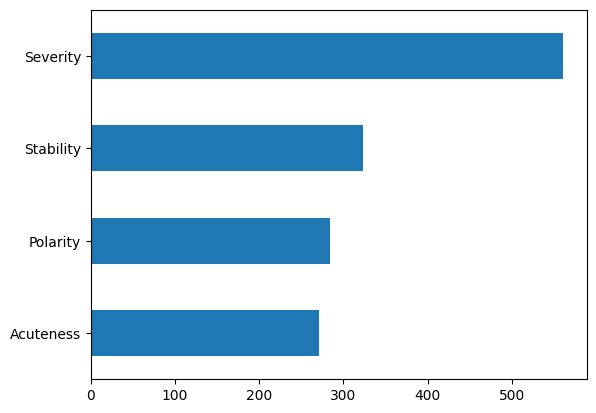

In [250]:
df_ents[qualifier_idx].Category.value_counts().sort_values().plot(kind = 'barh')

In [251]:
df_ents[qualifier_idx & (df_ents.Category == 'Modifier')].head(60)

,Id,Entity_id,Mention,Category,Start_char,End_char,Char_spans,Category_chia,Type


In [252]:
df_ents.loc[qualifier_idx, 'Category_chia'] = 'Qualifier'

## 4.4 Build _Measurement_ category

[Table of content](#TOC)


Observations are organized into 6 types, plus an additional unspecified type, which we map differently to either _Measurement_ or _Observation_ OMOP-compatible category:

| Type | Target category |
|-----|-----|
| measurement | Measurement | 
| lab | Measurement | 
| vital | Measurement | 
| clinical-score | Measurement | 
| social-habit | Observation |
| survey-or-questionnaire | Observation |
|  | Observation |


See the Leaf Clinical Trial Corpus wiki on [Observation](https://github.com/uw-bionlp/clinical-trials-gov-annotation/wiki/observation) and its decomposition into types.

<AxesSubplot: >

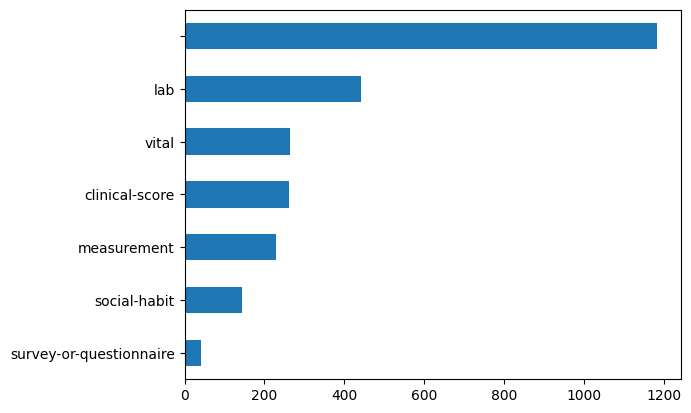

In [253]:
df_ents[(df_ents.Category == 'Observation')].Type.value_counts().sort_values().plot(kind = 'barh')

In [254]:
measurement_idx = (
    (df_ents.Category == 'Observation')
) & df_ents.Type.isin([
    'measurement',
    'lab',
    'vital',
    'clinical-score',
])

In [255]:
sum(measurement_idx)

1195

In [256]:
df_ents.loc[measurement_idx, 'Category_chia'] = 'Measurement'

## 4.5 Build _Value & Temporal_ categories

[Table of content](#TOC)

In [257]:
def get_ancestor(nx_graph, node_id, level = 1):
    '''
    This function rely on the fact that each node has a single parent,
    and its normalization is unique, if it exists.
    '''
    parents = list(nx_graph.predecessors(node_id))
    if len(parents) >= level:
        parent = nx_graph.nodes[parents[level-1]]
        p_cat  = parent['Category']
        p_type = (parent['Normalization'][0][-1] if parent['Normalization'] else '')
        return (p_cat, p_type)
    return ('', '')

In [258]:
def get_ancestor_path(nx_graph, node, return_ancestor_level = 2):
    ancestors = nx.ancestors(nx_graph, node)
    if ancestors:
        paths = [nx.shortest_path(nx_graph, source = a, target = node) for a in ancestors]
        path = tuple(sorted(paths, key = len)[-1])
        root = path[-return_ancestor_level:][0]
        path = [
            nx_graph.get_edge_data(m, n)[0]['label']
            for m, n in zip(path[:-1], path[1:])
        ]
        path = [root, path]
    else:
        path = [node, tuple([])]
    return path



def get_descendant_paths(nx_graph, node, from_ancestor_level = 1):
    if from_ancestor_level == 0:
        root = node
    else:
        ancestors = nx.ancestors(nx_graph, node)
        if ancestors:
            paths = [nx.shortest_path(nx_graph, source = a, target = node) for a in ancestors]
            path = tuple(sorted(paths, key = len)[-1])
            root = path[-from_ancestor_level:][0]
        else:
            root = node
    return list(set([nx_graph.nodes[n]['Category'] for n in nx.descendants(nx_graph, root)]))



def get_children_edges(nx_graph, node):
    return [e['label'] for s, t, e in nx_graph.out_edges(node, data = True)]
    


def get_overlaping_entities(row, df, output_column = 'index'):
    # get entities on same Id
    df = df[df.Id == row.Id]
    df = df[df.Entity_id != row.Entity_id]
    
    lengths = df.End_char - df.Start_char
    length = row.End_char - row.Start_char
    
    idx_short = []
    idx_equal = []
    idx_large = []

    # get shorter overlaping entities
    df_short = df[lengths <= length]
    if not df_short.empty:
        short = df_short.apply(
            func = lambda r: len(set(range(r.Start_char, r.End_char)) & set(range(row.Start_char, row.End_char)))>0, 
            axis = 1,
        )
        idx_short = df_short[short][output_column].tolist()
    
    # get identical overlaping entities
    df_equal = df[lengths == length]
    if not df_equal.empty:
        equal = df_equal.apply(
            func = lambda r: (r.Start_char == row.Start_char) & (r.End_char == row.End_char), 
            axis = 1,
        )
        idx_equal = df_equal[equal][output_column].tolist()

    # get larger overlaping entities
    df_large = df[lengths > length]
    if not df_large.empty:
        large = df_large.apply(
            func = lambda r: len(set(range(r.Start_char, r.End_char)) & set(range(row.Start_char, row.End_char)))>0, 
            axis = 1,
        )
        idx_large = df_large[large][output_column].tolist()
    return (idx_short, idx_equal, idx_large)

In [259]:
df_comps = df_ents[df_ents.Category == 'Eq-Comparison'].copy()
df_comps

,Id,Entity_id,Mention,Category,Start_char,End_char,Char_spans,Category_chia,Type
26,NCT03865342,T29,>5 lbs,Eq-Comparison,292,298,"(292, 298)",Eq-Comparison,
27,NCT03865342,T30,within the past 3 months,Eq-Comparison,673,697,"(673, 697)",Eq-Comparison,
29,NCT03865342,T32,18 years of age and older,Eq-Comparison,47,72,"(47, 72)",Eq-Comparison,
35,NCT03865342,T41,5.7 - 6.4,Eq-Comparison,137,146,"(137, 146)",Eq-Comparison,
36,NCT03865342,T42,within the 3 months,Eq-Comparison,147,166,"(147, 166)",Eq-Comparison,
...,...,...,...,...,...,...,...,...,...
56058,NCT03931772,T29,≥ 5 out of 10,Eq-Comparison,150,163,"(150, 163)",Eq-Comparison,
56062,NCT03931772,T73,current,Eq-Comparison,671,678,"(671, 678)",Eq-Comparison,
56066,NCT03931772,T77,Currently taking,Eq-Comparison,912,928,"(912, 928)",Eq-Comparison,
56079,NCT03931772,T87,daily,Eq-Comparison,302,307,"(302, 307)",Eq-Comparison,


In [260]:
root_ancestor = df_comps.apply(
    func = lambda r: get_ancestor_path(nx_graph, '-'.join([r.Id, r.Entity_id])),
    axis = 1,
).tolist()

df_comps['Root'] = [r for r, a in root_ancestor]
df_comps['Ancestors'] = [a for r, a in root_ancestor]
df_comps['Root_edges'] = df_comps.Root.apply(lambda r: get_children_edges(nx_graph, r))
df_comps['Overlaping'] = df_comps.apply(
    func = lambda r: get_overlaping_entities(r, df_ents, output_column = 'Category'),
    axis = 1,
)

In [261]:
df_comps.head(2)

,Id,Entity_id,Mention,Category,Start_char,End_char,Char_spans,Category_chia,Type,Root,Ancestors,Root_edges,Overlaping
26,NCT03865342,T29,>5 lbs,Eq-Comparison,292,298,"(292, 298)",Eq-Comparison,,NCT03865342-E6,"[Numeric-Filter, Eq-Comparison]","[Eq-Comparison, Operator, Unit, Value]","([Eq-Operator, Eq-Unit, Eq-Value], [], [])"
27,NCT03865342,T30,within the past 3 months,Eq-Comparison,673,697,"(673, 697)",Eq-Comparison,,NCT03865342-E7,"[Temporality, Eq-Comparison]","[Eq-Comparison, Operator, Temporal-Unit, Value...","([Eq-Operator, Eq-Temporal-Unit, Eq-Value, Eq-..."


In [262]:
other_filter = df_comps.Overlaping.apply(lambda os: len(set(os[1]) & set([
    'Eq-Temporal-Recency', 'Eq-Temporal-Unit', 'Severity', 'Eq-Operator',
])) > 0)

print(sum(other_filter))


temporal_cats = ['Temporality', 'Temporality2', 'Temporality3', 'During', 'Duration', 'Duration2'] # Before, After

temporal_filter = ~other_filter & (
    df_comps.Overlaping.apply(lambda os: (os[1] == ['Eq-Temporal-Period'])) |
    df_comps.Ancestors.apply(lambda a: (len(a)>1 and a[-2] in temporal_cats)) 
)

print(sum(temporal_filter))

value_cats = ['Numeric-Filter', 'Stage', 'Dose', 'Dose2']

value_filter = ~(other_filter | temporal_filter) & (
    df_comps.Ancestors.apply(lambda a: (len(a)>1 and a[-2] in value_cats))
)

print(sum(value_filter))


temporal_filter_2 = ~(other_filter | temporal_filter | value_filter) & (
    df_comps.Overlaping.apply(lambda os: ('Eq-Temporal-Unit' in os[0]))
)

print(sum(temporal_filter_2))


value_filter_2 = ~(other_filter | temporal_filter | value_filter | temporal_filter_2) & (
    df_comps.Overlaping.apply(lambda os: ('Eq-Value' in os[0]))
)

print(sum(value_filter_2))

other_filter_2 = ~(other_filter | temporal_filter | value_filter | temporal_filter_2 | value_filter_2)

print(sum(other_filter_2))

196
2628
1985
137
313
38


In [ ]:
value_filter_3 = (
    (df_ents.Category == 'Polarity')
) & df_ents.Type.isin([
    'measurement',
    'lab',
    'vital',
    'clinical-score',
])

In [263]:
temporal_idx = df_comps[temporal_filter | temporal_filter_2].index.tolist()
len(temporal_idx)

2765

In [264]:
value_idx = df_comps[value_filter | value_filter_2 | value_filter_3].index.tolist()
len(value_idx)

2298

In [265]:
# sanity check: these sets of indices are disjoint
len(set(value_idx) & set(temporal_idx))

0

In [266]:
df_ents.loc[temporal_idx, 'Category_chia'] = 'Temporal'
df_ents.loc[value_idx, 'Category_chia'] = 'Value'

## 4.6 Get flattened non-overlapping entities

[Table of content](#TOC)


In [267]:
categories_chia = [
    # domain
    'Condition',
    'Procedure',
    'Drug',
    'Person',      # created from 'Life-Stage-And-Gender' and 'Age'
    'Measurement', # created from subset of 'Observation'
    'Observation', # created from subset of 'Observation'
    # 'Device' missing
    
    # field
    'Value',     # replaces part of 'Eq-Comparison'
    'Temporal',  # replaces part of 'Eq-Comparison'
    'Qualifier', # replaces 'Modifier', 'Severity', 'Assertion', 'Stability', 'Acuteness', 'Polarity'
]

In [268]:
df_ents = df_ents[df_ents.Category_chia.isin(categories_chia)].reset_index(drop = True).copy()
df_ents.loc[:, 'Category'] = df_ents.Category_chia
df_ents.shape

(21988, 9)

In [275]:
df_flat = get_ner_entities(df_texts, df_ents, categories_chia) 
df_flat.shape

(21784, 6)

In [276]:
df_flat.head()

,Id,Mention,Start_char,End_char,Entity_id,Category
0,NCT03860012,inflammatory bowel disease,25,51,"(T13,)",Condition
1,NCT03860012,on,57,59,"(T31,)",Temporal
2,NCT03860012,methotrexate,60,72,"(T15,)",Drug
3,NCT03860012,folate levels,107,120,"(T17,)",Measurement
4,NCT03860012,treatment,144,153,"(T26,)",Procedure


<AxesSubplot: >

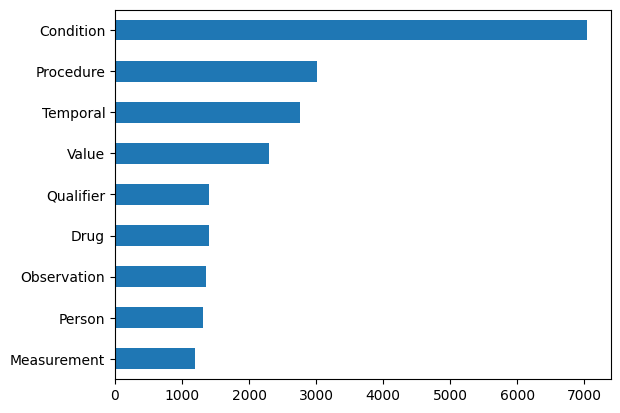

In [277]:
df_flat.Category.value_counts().sort_values().plot(kind = 'barh')

In [278]:
df_flat.to_csv(os.path.join(path_to_data, final_dataset_name, 'lct_ents.tsv'), sep = "\t", index = False)

## 4.7 Convert entities to BIO format

[Table of content](#TOC)


In [279]:
df_spans = convert_to_bio(df_texts, df_flat)
df_spans.shape

(50724, 4)

In [280]:
df_spans.to_csv(os.path.join(path_to_data, final_dataset_name, 'lct_spans.tsv'), sep = "\t", index = False)

In [281]:
tokenizer = English()

df_bio = convert_to_bio(df_texts, df_flat, tokenizer = lambda s: [t.text for t in tokenizer(s)])
df_bio.shape

(145911, 4)

In [282]:
df_bio.head()

,Id,Sequence_id,Mention,Category
0,NCT03862404,NCT03862404_0,Inclusion,O
1,NCT03862404,NCT03862404_0,Criteria,O
2,NCT03862404,NCT03862404_0,:,O
3,NCT03862404,NCT03862404_1,,O
4,NCT03862404,NCT03862404_1,-,O


In [283]:
df_bio.to_csv(os.path.join(path_to_data, final_dataset_name, 'lct_bio.tsv'), sep = "\t", index = False)

[Table of content](#TOC)